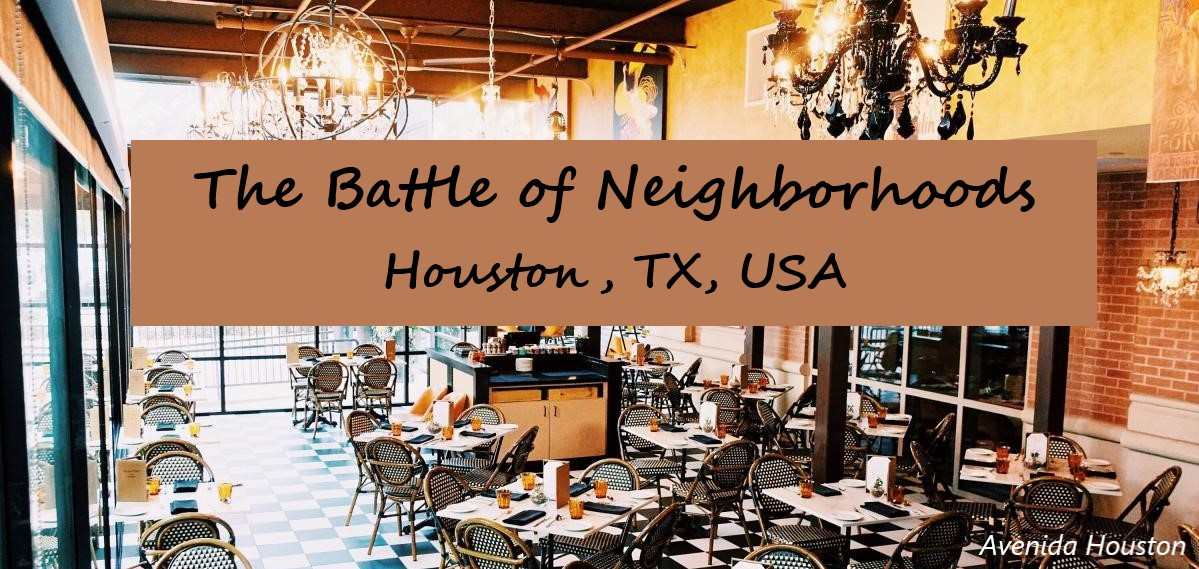

## <center>The Battle of Neighborhoods</center>
### <center>Applied Data Science Capstone by IBM/Coursera</center>

## <center>Finding the best neighborhood in Houston to open a bar</center>


## 0. Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#method)
* [Analysis](#analysis)
* [Result and Discussion](#result)
* [Conclusion](#conclusion)
* [Future Work](#future)

## 1. Introduction <a name="introduction"></a>

**Background:**        
Houston is the most populous city in the U.S. state of Texas, fourth-most populous city in the United States, most populous city in the Southern United States. Houston is also one of the most multicultural cities in U.S., making life in Houston a wonderful multicultural experience for all. Houston is also well-known for its great food and drinks.   
As a young adult in Houston, I really enjoy hanging out with friends in different bars. Of course, there are hundreds of great bars here in Houston. It always be one of my dreams, that someday I can have my own bar opened here in the city. If so, where should I open it?


**Problem Description:**   
The objective of this project is to find the best neighborhood in Houston to open a bar using Foursquare location data. We will use the data science and machine learning tools we know to analyze the data and get a conclusion for the stakeholder to make a decision.

**Target Audience:**   
* Small business owners who want to open their own bars;
* Tourist who is looking for a bar in the city;
* Investors who want to invest a bar in Houston.

## 2. Data <a name="data"></a>

The data we need:  
1. A list of Houston neighborhood data  
**Data Source:** https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Houston  
**Description:** This Wikipedia page contains a list of neighborhoods in Houston. We will scrape and clean the data, and read it into a pandas data frame.

  
2. Geographical coordinates of each neighborhoods  
**Data Source:**  using **Google Geoencoding API**   
**Description:** The second data provides the geographical coordinates of each neighborhood in Houston.

  
3. Venue Data using Foursquare API  
**Data Source:** https://foursquare.com/developers/apps  
**Description:** From Foursquare API we can get the name, category, latitude, longitude for each venue.  

## 3. Methodology <a name="method"></a>

### 3.1 Installing packages and libraries

In [ ]:
# install requests to gain access to an URL
!pip install requests

# install beautifulsoup4 for web scraping
!pip install beautifulsoup4

# install folium for visualization
!pip install folium

# install sklearn
!pip install -U scikit-learn

# install kmeans for clustering
!pip install kmeans

print("Packages installed!")

In [1]:
# import all necessary libraries
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('precision', 9)

import json # library to handle JSON files

from bs4 import BeautifulSoup
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib 
import matplotlib.pyplot as plt 

# import k-means from clustering stage
from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library
from folium.features import DivIcon

print('Libraries imported!')

Libraries imported!


### 3.2 Data Scraping
#### Scrape Houston Neighborhood data

In [2]:
# scrape neighborhoods data using beautiful soup
url = "https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Houston"
source = requests.get(url)
data_html = BeautifulSoup(source.content)
# data_html

In [13]:
# data_html.table

In [14]:
from IPython.display import display_html
tab = str(data_html.table)
# display_html(tab,raw=True)

In [150]:
# drop useless columns and rename the columns
dfs = pd.read_html(tab)
df = dfs[0]
df.drop(columns=['Approximate boundaries', "#"], axis=1, inplace=True)
# df.set_index('#', inplace=True)
df.rename(columns={'Location relative to Downtown Houston':'Location', 'Name':'Neighborhood' }, inplace=True)
df.shape

(88, 2)

In [151]:
df.index += 1
df

,Neighborhood,Location
1,Willowbrook,Northwest
2,Greater Greenspoint,North
3,Carverdale,Northwest
4,Fairbanks / Northwest Crossing,Northwest
5,Greater Inwood,Northwest
6,Acres Home,Northwest
7,Hidden Valley,North
8,Westbranch,West
9,Addicks / Park Ten,West
10,Spring Branch West,West


#### Get Coordinates for Each Neighborhood Using Google Map API: Geoencoding
I was trying the **geopy** library to get coordinates for each neighborhood and print them out the map.  
It turns out **geopy** couldn't get all the coordinates, and some of the coordinates are not at where they are surposed to be on map according to the "Location" from the data I graped.  
So I decided to get all coordinates using **Google Geoencoding API**.

In [325]:
################################################
# !!! Put your Google Geoencoding API key here !!!
################################################
api_key = ''


In [10]:
def google_get_coordinates(api_key, address, verbose=False):
    try:
        url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(address, api_key)
        response = requests.get(url).json()
        if verbose:
            print('Google Maps API JSON result =>', response)
        results = response['results']
        geographical_data = results[0]['geometry']['location'] # get geographical coordinates
        lat = geographical_data['lat']
        lon = geographical_data['lng']
        return [lat, lon]
    except:
        return [None, None]
    
# address = 'Alexanderplatz, Berlin, Germany'
# berlin_center = get_coordinates(google_api_key, address)
# print('Coordinate of {}: {}'.format(address, berlin_center))

### 3.3 Data Cleaning

#### Looks like some neighborhoods have different names.
Some "Neighborhood" variables contain special characters: "/",  "(",  ")".  
I need to seperate them and get the valid name(s) for each neighborhood.

In [11]:
# test string seperator for different neighborhood name cases
myStr1 = "Mid-West (formerly Woodlake/Briarmeadow)"
myStr2 = "Washington Avenue Coalition / Memorial Park"
myStr3 = "Brays Oaks (formerly Greater Fondren S.W.)"
myStr4 = "University Place"
def mySeperator(myStr):
    return myStr.replace(" (formerly ","  ").replace(")", "").replace(" / ", "  ").replace("/", "  ").split("  ")

# mySeperator(myStr1)
# mySeperator(myStr2)
# mySeperator(myStr3)
mySeperator(myStr4)

['University Place']

#### In some of the cases, the different names of the neighborhood have different coordinates.
I decided to use the average of all coordinates as the final coordinate to the neighborhood.  


In [12]:
#For example, df["Neighborhood"] = "Central Northwest (formerly Near Northwest)"
print(google_get_coordinates(api_key, "Near Northwest, Houston, TX"))
print(google_get_coordinates(api_key, "formerly Near Northwest, Houston, TX"))
print(google_get_coordinates(api_key, "Central Northwest, Houston, TX"))

[29.8455647, -95.50633499999999]
[29.875183, -95.47490359999999]
[29.8327499, -95.4448031]


#### So when I loop through all neighborhoods, I will deal with the multi-name issue by seperating the "Neighborhood" and averaging various coordinates.

In [322]:
## average the coordinates with multiple names
def get_avg_coordinates(row_index=36, print_out=False, input_key=api_key):
    neighborhood = df.loc[row_index, 'Neighborhood']
    names = mySeperator(neighborhood)
    lats, lngs = [], []
    for name in names:
        address = neighborhood + ", Houston, TX"
        lat, lng = google_get_coordinates(input_key, address)
        lats.append(lat)
        lngs.append(lng)
    fn_lat = sum(lats)/len(lats)
    fn_lng = sum(lngs)/len(lngs)
    if print_out:
        print(neighborhood, fn_lat, fn_lng)
    return fn_lat, fn_lng

## test the averaging function with "36, Brays Oaks (formerly Greater Fondren S.W.)"
# get_avg_coordinates(row_index=36, print_out=True)


In [ ]:
## loop through all neighborhoods to get coordinates (average)
for row_index in range(1, df.shape[0]+1):
    df.loc[row_index, 'Latitude'], df.loc[row_index, 'Longitude'] = get_avg_coordinates(row_index)
print("done!")
df.shape
# df

In [154]:
df.dtypes

Neighborhood     object
Location         object
Latitude        float64
Longitude       float64
dtype: object

In [155]:
df

,Neighborhood,Location,Latitude,Longitude
1,Willowbrook,Northwest,29.9558598,-95.5459787
2,Greater Greenspoint,North,29.9406789,-95.4139056
3,Carverdale,Northwest,29.8587078,-95.5451620
4,Fairbanks / Northwest Crossing,Northwest,29.8509122,-95.5154068
5,Greater Inwood,Northwest,29.8657387,-95.4804344
6,Acres Home,Northwest,29.8707190,-95.4365430
7,Hidden Valley,North,29.8896157,-95.4181974
8,Westbranch,West,29.8382464,-95.5520192
9,Addicks / Park Ten,West,29.8132687,-95.6454759
10,Spring Branch West,West,29.7908472,-95.5446297


#### There are still two neighborhoods overlapped on map (shared the same coordinates):
10,	Spring Branch West,	West,	29.790847,	-95.544630   
86,	Spring Branch East,	Northwest,	29.790847,	-95.544630

In [144]:
print("Spring Branch West", google_get_coordinates(api_key, "Spring Branch West, Houston, TX"))
print("Spring Branch East", google_get_coordinates(api_key, "Spring Branch East, Houston, TX"))

Spring Branch West [29.7908472, -95.5446297]
Spring Branch East [29.7908472, -95.5446297]


In [145]:
print("*West Spring Branch", google_get_coordinates(api_key, "West Spring Branch, Houston, TX"))
print("*East Spring Branch", google_get_coordinates(api_key, "East Spring Branch, Houston, TX"))

*West Spring Branch [29.7908472, -95.5446297]
*East Spring Branch [29.8028554, -95.4754992]


In [146]:
print("*Central Spring Branch", google_get_coordinates(api_key, "Central Spring Branch, Houston, TX"))
print("Spring Branch Central", google_get_coordinates(api_key, "Spring Branch Central, Houston, TX"))
print("*North Spring Branch", google_get_coordinates(api_key, "North Spring Branch, Houston, TX"))
print("Spring Branch North", google_get_coordinates(api_key, "Spring Branch North, Houston, TX"))

*Central Spring Branch [29.8110812, -95.5095815]
Spring Branch Central [29.8110812, -95.5095815]
*North Spring Branch [29.7908472, -95.5446297]
Spring Branch North [29.8227034, -95.5452559]


In [124]:
get_avg_coordinates(10)

(29.7908472, -95.5446297)

#### I decided to manually replace the coordinate of "Spring Branch East" with the coordinate got from "East Spring Branch".

In [158]:
idx = 10
print("Before correction: ", df.loc[idx])
alter_address = "East Spring Branch, Houston, TX"
df.loc[idx, 'Latitude'], df.loc[idx, 'Longitude'] = google_get_coordinates(api_key, alter_address)
print("After correction: ", df.loc[idx])

Before correction:  Neighborhood    Spring Branch West
Location                      West
Latitude                29.7908472
Longitude              -95.5446297
Name: 10, dtype: object
After correction:  Neighborhood    Spring Branch West
Location                      West
Latitude                29.8028554
Longitude              -95.4754992
Name: 10, dtype: object


In [148]:
# df

,Neighborhood,Location,Latitude,Longitude
1,Willowbrook,Northwest,29.9558598,-95.5459787
2,Greater Greenspoint,North,29.9406789,-95.4139056
3,Carverdale,Northwest,29.8587078,-95.5451620
4,Fairbanks / Northwest Crossing,Northwest,29.8509122,-95.5154068
5,Greater Inwood,Northwest,29.8657387,-95.4804344
6,Acres Home,Northwest,29.8707190,-95.4365430
7,Hidden Valley,North,29.8896157,-95.4181974
8,Westbranch,West,29.8382464,-95.5520192
9,Addicks / Park Ten,West,29.8132687,-95.6454759
10,Spring Branch West,West,29.8028554,-95.4754992


### 3.4 Saving and Reading Intermediate Dataset

#### Save clean data into CSV file
After all the data cleaning, now the dataset is ready for further analysis.   
Last save time: 10/02/2021, 7:39 PM

In [160]:
# save clean dataframe into local *.csv file
df.to_csv('Houston_Neighborhood_Data.csv')

#### Read clean data from CSV into Dataframe

In [317]:
df = pd.read_csv("Houston_Neighborhood_Data.csv",index_col=0)
df

,Neighborhood,Location,Latitude,Longitude
1,Willowbrook,Northwest,29.9558598,-95.5459787
2,Greater Greenspoint,North,29.9406789,-95.4139056
3,Carverdale,Northwest,29.8587078,-95.5451620
4,Fairbanks / Northwest Crossing,Northwest,29.8509122,-95.5154068
5,Greater Inwood,Northwest,29.8657387,-95.4804344
6,Acres Home,Northwest,29.8707190,-95.4365430
7,Hidden Valley,North,29.8896157,-95.4181974
8,Westbranch,West,29.8382464,-95.5520192
9,Addicks / Park Ten,West,29.8132687,-95.6454759
10,Spring Branch West,West,29.8028554,-95.4754992


### 3.5 Interactive Data Visualization 
#### Folium Map

In [323]:
color_list = {'red':'#FF0000',
              'yellow':'#FFFF00',
              'lime':'#00FF00',
              'aqua':'#00FFFF',
              'blue':'#0000FF',
              'fuchsia':'#FF00FF',
              'orange':'#FFA500',
              'green':'#008000',
              'olive':'#808000',
              'pink':'#FFC0CB',
              'navy':'#000080'}

# This will color categorize neighborhoods in each part of Houston
# get the list of locations of the neighborhoods, and a list of color names
locations = df['Location'].unique().tolist()
color_names = list(color_list.keys())

# assign color to each location
loc_color = {}
for location, color_name in zip(locations, color_names[:len(locations)]):
    loc_color[location] = color_list[color_name]


# get center coordinates of Houston and map it
lat_hou, lon_hou = google_get_coordinates(api_key, "Houston, TX")
map_houston = folium.Map(location=[lat_hou, lon_hou], zoom_start=10)


# add markers to map
for idx, lat, lng, location, neighborhood in zip(range(df.shape[0]),
                                                 df['Latitude'],
                                                 df['Longitude'],
                                                 df['Location'], 
                                                 df['Neighborhood']):

    label_text = location + ' - ' + neighborhood
    label = folium.Popup(label_text)
    folium.Circle([lat, lng],
                  fill=True,
                  radius=800,
                  popup=label,
                  color=loc_color[location]).add_to(map_houston)

#     icon_html = '<div style="font-size: 10pt; color:black"><b>%s</b></div>'%(idx+1)
    icon_html = '<div style="font-size: 10pt; color:black"><t>%s</t></div>'%(idx+1)

#     print(icon_html, '\n')
    folium.map.Marker([lat, lng],
                      icon=DivIcon(
                          icon_size=(50,12),                                    
                          icon_anchor=(10,10),
                          html=icon_html,
                          )
                     ).add_to(map_houston)
map_houston

*Please copy this Github URL to "https://nbviewer.jupyter.org/ to see interactive Folium map.

### 3.6 Getting Venues Using Foursquare
To get the nearby venues for each coordinates, radius about 1 mile, up to 100 venues for each neighborhood.

In [326]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20210909' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


In [19]:
## test/default data: "westchase", 29.727756, -95.571662
def get_nearby_venues(name="westchase", lat=29.727756, lng=-95.571662, radius=1600, LIMIT=100):
    venues_list=[]
    # create the API request URL
    url_format = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'
    url = url_format.format(CLIENT_ID,CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
        
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    # return only relevant information for each nearby venue
    venues_list.append([(
        name, 
        lat, 
        lng, 
        v['venue']['name'], 
        v['venue']['location']['lat'], 
        v['venue']['location']['lng'],  
        v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return nearby_venues
#     return venues_list

In [20]:
## Test run to get nearby venues
get_nearby_venues()
# get_nearby_venues("Fondren Gardens", 29.6263258, -95.5012732)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,westchase,29.727756,-95.571662,Avesta Persian Grill,29.734642702,-95.571326287,Persian Restaurant
1,westchase,29.727756,-95.571662,Cantina Laredo,29.734845691,-95.572293469,Mexican Restaurant
2,westchase,29.727756,-95.571662,Whole Foods Market,29.735312616,-95.570391224,Grocery Store
3,westchase,29.727756,-95.571662,Torchy's Tacos,29.735193000,-95.571233800,Taco Place
4,westchase,29.727756,-95.571662,Salata,29.737289300,-95.568270800,Salad Place
5,westchase,29.727756,-95.571662,Kim's Teahouse,29.737477058,-95.569377259,Tea Room
6,westchase,29.727756,-95.571662,Jason's Deli,29.736211917,-95.571210482,Food Truck
7,westchase,29.727756,-95.571662,Nippan Daido,29.737520783,-95.572632123,Grocery Store
8,westchase,29.727756,-95.571662,Genji Japanese Restaurant & Karaoke Bar,29.737352218,-95.572907769,Japanese Restaurant
9,westchase,29.727756,-95.571662,North Shore Poke Co.,29.736202302,-95.572773580,Hawaiian Restaurant


In [64]:
## test pd.concat
# df1 = get_nearby_venues()
# df2 = get_nearby_venues("Greater Greenspoint",29.940679,-95.413906)
# col_names = ['Neighborhood', 
#               'Neighborhood Latitude', 
#               'Neighborhood Longitude', 
#               'Venue', 
#               'Venue Latitude', 
#               'Venue Longitude', 
#               'Venue Category']
# pd.concat([df1,df2], keys=col_names,ignore_index=True)

In [22]:
## Get venues for all neighborhoods in our dataset
col_names = ['Neighborhood', 
              'Neighborhood Latitude', 
              'Neighborhood Longitude', 
              'Venue', 
              'Venue Latitude', 
              'Venue Longitude', 
              'Venue Category']

houston_venues = pd.DataFrame(columns=col_names)

for idx, name, lat, lng in zip(df.index, df['Neighborhood'], df['Latitude'], df['Longitude']):
    temp = get_nearby_venues(name, lat, lng)
    houston_venues = pd.concat([houston_venues, temp], keys=col_names, ignore_index=True)
    
houston_venues.shape

(4168, 7)

In [23]:
houston_venues.tail()
# houston_venues.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
4163,Lawndale / Wayside,29.7247703,-95.3112419,Burger King,29.736864200,-95.307390100,Fast Food Restaurant
4164,Lawndale / Wayside,29.7247703,-95.3112419,Taqueria Los Charros,29.737617000,-95.307508000,Mexican Restaurant
4165,Lawndale / Wayside,29.7247703,-95.3112419,Sprint Store,29.711409000,-95.313556000,Mobile Phone Shop
4166,Lawndale / Wayside,29.7247703,-95.3112419,WokkerTXRanger,29.711160597,-95.309757804,Food Truck
4167,Lawndale / Wayside,29.7247703,-95.3112419,Turimex International,29.735379346,-95.300747880,Bus Station


### 3.7 Saving and Reading Intermediate Dataset Again

#### Save houston_venues to CSV file
Last saved: 10/03/2021, 9:40 PM

In [24]:
houston_venues.to_csv("Houston_Venues.csv")

#### Read data from CSV to dataframe

In [327]:
houston_venues = pd.read_csv("Houston_Venues.csv", index_col=0)
houston_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Willowbrook,29.9558598,-95.5459787,Costco,29.954658065,-95.547697293,Warehouse Store
1,Willowbrook,29.9558598,-95.5459787,Babin's Seafood House,29.955087888,-95.544452143,Seafood Restaurant
2,Willowbrook,29.9558598,-95.5459787,Pho An 2,29.956605817,-95.543805040,Vietnamese Restaurant
3,Willowbrook,29.9558598,-95.5459787,REI,29.957922300,-95.547228100,Sporting Goods Shop
4,Willowbrook,29.9558598,-95.5459787,Mint Thai Kitchen,29.956059844,-95.544429548,Thai Restaurant


## 4. Data Analysis <a name="analysis"></a>

### 4.1. Exploratory Data Analysis

#### Q1. How many venues in each neighborhood?

In [328]:
count_venues = houston_venues.groupby('Neighborhood').count()
count_venues.shape

(88, 6)

In [330]:
count_venues

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Acres Home,4,4,4,4,4,4
Addicks / Park Ten,5,5,5,5,5,5
Afton Oaks / River Oaks,100,100,100,100,100,100
Alief,30,30,30,30,30,30
Astrodome Area,92,92,92,92,92,92
Braeburn,49,49,49,49,49,49
Braeswood,27,27,27,27,27,27
Brays Oaks (formerly Greater Fondren S.W.),23,23,23,23,23,23
Briar Forest,88,88,88,88,88,88


#### Q2. How many unique venues are there in all neighborhood?

In [27]:
hou_unique_venues = houston_venues['Venue Category'].unique()
hou_unique_venues = np.sort(hou_unique_venues)
# hou_unique_venues
print('There are {} unique venue categories.\n'.format(len(hou_unique_venues)))

print("The categories are:")
for idx, venue in enumerate(hou_unique_venues):
    print(idx+1, venue)
    
print('\nThere are {} unique venue categories.'.format(len(hou_unique_venues)))

There are 334 unique venue categories.

The categories are:
1 Accessories Store
2 Advertising Agency
3 Afghan Restaurant
4 African Restaurant
5 Airport
6 Airport Lounge
7 Airport Service
8 Airport Terminal
9 American Restaurant
10 Animal Shelter
11 Aquarium
12 Arcade
13 Argentinian Restaurant
14 Art Gallery
15 Art Museum
16 Arts & Crafts Store
17 Arts & Entertainment
18 Asian Restaurant
19 Assisted Living
20 Athletics & Sports
21 Auto Garage
22 Auto Workshop
23 Automotive Shop
24 BBQ Joint
25 Bagel Shop
26 Bakery
27 Bank
28 Bar
29 Baseball Field
30 Baseball Stadium
31 Basketball Court
32 Basketball Stadium
33 Bay
34 Beer Bar
35 Beer Garden
36 Beer Store
37 Big Box Store
38 Bike Shop
39 Bistro
40 Boat or Ferry
41 Bookstore
42 Botanical Garden
43 Boutique
44 Bowling Alley
45 Brazilian Restaurant
46 Breakfast Spot
47 Brewery
48 Bubble Tea Shop
49 Buffet
50 Building
51 Burger Joint
52 Burrito Place
53 Bus Station
54 Business Service
55 Butcher
56 Cafeteria
57 Café
58 Cajun / Creole Restaur

#### Q3. Are there any bars present in the venues?

In [28]:
"Bar" in hou_unique_venues

True

In [29]:
"Cocktail Bar" in hou_unique_venues

True

In [30]:
"Neighborhood" in hou_unique_venues

True

 #### Q4. How many different bars or pubs in Houston?

In [31]:
## define a function to categorize venues into groups
def category_venue_by_keyword(category_name="no name", venue_list=[], word_list=[], exclude_list=[], print_out=True):  
    out_list = []
    for venue in venue_list:
        flag = 0
        for word in exclude_list:
            if word in venue.lower():
                flag = 1
                break
        if flag:
            continue
        else:
            for word in word_list:
                if word in venue.lower():
                    out_list.append(venue)
                    break
    if print_out:    
        print("Before removing {}, we have {} venues.".format(category_name, len(venue_list)))
        venue_list = [v for v in venue_list if v not in out_list]
        print("after removing {}, we have {} venues.".format(category_name, len(venue_list)))

        print("There are {} kinds of {}s in Houston.".format(len(out_list), category_name))
        print(houston_venues['Venue Category'].value_counts()[out_list])
    return venue_list, out_list

In [32]:
## make a copy of hou_unique_venues
venue_list = hou_unique_venues.copy().tolist()

## collect all list into one dectionary
all_groups = {}

In [33]:
## get all bars
name = "bar"
word_list = ["bar", "pub"]
exclude_list = ["public", "barber"]
after_list, out_list = category_venue_by_keyword(name, venue_list, word_list, exclude_list)
all_groups[name] = out_list
all_groups.keys()

Before removing bar, we have 334 venues.
after removing bar, we have 318 venues.
There are 16 kinds of bars in Houston.
Bar             66
Beer Bar         7
Cocktail Bar    13
Dive Bar        11
Gastropub        5
Gay Bar          3
Hookah Bar       1
Hotel Bar        3
Irish Pub        2
Juice Bar       12
Karaoke Bar      3
Pub             10
Sports Bar      23
Tiki Bar         1
Whisky Bar       2
Wine Bar        17
Name: Venue Category, dtype: int64


dict_keys(['bar'])

#### Q5. What other kinds of venues do we have?

In [34]:
## get all restaurants
name = "restaurant"
word_list = ["restaurant"]
venue_list = after_list
after_list, out_list = category_venue_by_keyword(name, venue_list, word_list)
all_groups[name] = out_list
all_groups.keys()

Before removing restaurant, we have 318 venues.
after removing restaurant, we have 258 venues.
There are 60 kinds of restaurants in Houston.
Afghan Restaurant                    1
African Restaurant                   3
American Restaurant                 81
Argentinian Restaurant               2
Asian Restaurant                    16
Brazilian Restaurant                 3
Cajun / Creole Restaurant           28
Caribbean Restaurant                 3
Chinese Restaurant                  55
Comfort Food Restaurant              7
Cuban Restaurant                     2
Dim Sum Restaurant                   1
Dumpling Restaurant                  3
Eastern European Restaurant          1
Empanada Restaurant                  2
Falafel Restaurant                   1
Fast Food Restaurant               147
Filipino Restaurant                  3
French Restaurant                   20
German Restaurant                    1
Greek Restaurant                     6
Halal Restaurant                     1
H

dict_keys(['bar', 'restaurant'])

In [35]:
## get all other food and drink
name = "food_drink"
word_list = ["food", "drink", "beer", "joint", "brewery", "place", \
             "caf", "spot", "deli", "buffet", "diner", "noodle", "tea", "bistro", "bakery"]
venue_list = after_list
after_list, out_list = category_venue_by_keyword(name, venue_list, word_list)
all_groups[name] = out_list
all_groups.keys()

Before removing food_drink, we have 258 venues.
after removing food_drink, we have 222 venues.
There are 36 kinds of food_drinks in Houston.
BBQ Joint               42
Bakery                  49
Beer Garden              7
Beer Store               3
Bistro                   5
Breakfast Spot          39
Brewery                 17
Bubble Tea Shop          5
Buffet                   1
Burger Joint            89
Burrito Place            3
Cafeteria                1
Café                    36
College Cafeteria        1
Deli / Bodega           20
Diner                   10
Food                    12
Food & Drink Shop        3
Food Court               8
Food Service            11
Food Truck              51
Fried Chicken Joint     85
Gaming Cafe              1
Health Food Store        1
Hot Dog Joint            7
Mac & Cheese Joint       2
Noodle House             5
Pizza Place            125
Poke Place               1
Salad Place              6
Sandwich Place         117
Snack Place           

dict_keys(['bar', 'restaurant', 'food_drink'])

In [36]:
## get all shopping
name = "shopping"
word_list = ["shop", "store", "market"]
venue_list = after_list
after_list, out_list = category_venue_by_keyword(name, venue_list, word_list, exclude_list)
all_groups[name] = out_list
all_groups.keys()

Before removing shopping, we have 222 venues.
after removing shopping, we have 147 venues.
There are 75 kinds of shoppings in Houston.
Accessories Store                  4
Arts & Crafts Store                9
Auto Workshop                      2
Automotive Shop                    6
Bagel Shop                         8
Big Box Store                     10
Bike Shop                          2
Bookstore                          9
Camera Store                       2
Candy Store                        1
Chocolate Shop                     4
Clothing Store                    52
Coffee Shop                      101
Comic Shop                         1
Convenience Store                 41
Cosmetics Shop                    55
Cupcake Shop                       6
Department Store                  34
Dessert Shop                      10
Discount Store                    86
Donut Shop                        43
Duty-free Shop                     1
Electronics Store                 17
Fabric Shop   

dict_keys(['bar', 'restaurant', 'food_drink', 'shopping'])

In [37]:
## get all entertainment
name = "entertainment"
word_list = ["entertain", "club", "theater", "music", "opera"]
venue_list = after_list
after_list, out_list = category_venue_by_keyword(name, venue_list, word_list, exclude_list)
all_groups[name] = out_list
all_groups.keys()

Before removing entertainment, we have 147 venues.
after removing entertainment, we have 135 venues.
There are 12 kinds of entertainments in Houston.
Arts & Entertainment      1
College Theater           1
Comedy Club               1
General Entertainment     4
Indie Movie Theater       1
Jazz Club                 1
Movie Theater            10
Music Venue              11
Nightclub                10
Opera House               3
Sports Club               2
Theater                  15
Name: Venue Category, dtype: int64


dict_keys(['bar', 'restaurant', 'food_drink', 'shopping', 'entertainment'])

In [38]:
## get all outdoor
name = "outdoor"
word_list = ["outdoor", "sport", "gym", "rec center"]
exclude_list = ["transport"]
venue_list = after_list
after_list, out_list = category_venue_by_keyword(name, venue_list, word_list, exclude_list)
all_groups[name] = out_list
all_groups.keys()

Before removing outdoor, we have 135 venues.
after removing outdoor, we have 127 venues.
There are 8 kinds of outdoors in Houston.
Athletics & Sports        8
College Rec Center        2
Gym                      43
Gym / Fitness Center     30
Gymnastics Gym            1
Other Great Outdoors      1
Outdoor Sculpture         4
Outdoors & Recreation     4
Name: Venue Category, dtype: int64


dict_keys(['bar', 'restaurant', 'food_drink', 'shopping', 'entertainment', 'outdoor'])

In [39]:
print(len(after_list))
after_list

127


['Advertising Agency',
 'Airport',
 'Airport Lounge',
 'Airport Service',
 'Airport Terminal',
 'Animal Shelter',
 'Aquarium',
 'Arcade',
 'Art Gallery',
 'Art Museum',
 'Assisted Living',
 'Auto Garage',
 'Bank',
 'Baseball Field',
 'Baseball Stadium',
 'Basketball Court',
 'Basketball Stadium',
 'Bay',
 'Boat or Ferry',
 'Botanical Garden',
 'Boutique',
 'Bowling Alley',
 'Building',
 'Bus Station',
 'Business Service',
 'Butcher',
 'Casino',
 'Check Cashing Service',
 'Church',
 'Churrascaria',
 'Circus',
 'College Baseball Diamond',
 'College Football Field',
 'College Residence Hall',
 'Community Center',
 'Concert Hall',
 'Construction & Landscaping',
 'Creperie',
 'Cycle Studio',
 'Dance Studio',
 "Dentist's Office",
 "Doctor's Office",
 'Dog Run',
 'Dry Cleaner',
 'Event Service',
 'Exhibit',
 'Eye Doctor',
 'Financial or Legal Service',
 'Football Stadium',
 'Garden',
 'Garden Center',
 'Gas Station',
 'Go Kart Track',
 'Golf Course',
 'Golf Driving Range',
 'Government Buildi

In [40]:
all_groups["others"] = after_list

#### Q6. How many Neighborhoods for each venue?

In [41]:
group_venues_count = houston_venues.groupby('Venue Category').count()
group_venues_count.shape

(334, 6)

In [42]:
group_venues_count.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Accessories Store,4,4,4,4,4,4
Advertising Agency,2,2,2,2,2,2
Afghan Restaurant,1,1,1,1,1,1
African Restaurant,3,3,3,3,3,3
Airport,2,2,2,2,2,2


In [43]:
# group_venues_count.loc["Bar"]

### 4.2. Clustering the Neighborhoods
Using k-mean clustering 

#### One hot code to generate columns for each venue.
*Coincidentally, there is a venue called "Neighborhood". So be careful.

In [44]:
## one hot encoding
to_onehot = pd.get_dummies(houston_venues[['Venue Category']], prefix="", prefix_sep="")
print(to_onehot.shape)

## add neighborhood column back to dataframe
df1 = houston_venues[["Neighborhood"]]
df1.columns = ["Neighborhoods"]
hou_venues_onehot = pd.concat([df1, to_onehot], axis=1).reindex(to_onehot.index)
print(hou_venues_onehot.shape)
print(hou_venues_onehot.columns[:15])

hou_venues_onehot.sort_values(["Neighborhoods"], inplace=True, ignore_index=True)
hou_venues_onehot.head()

# # Alternative way to add neighborhood column back to dataframe
# # need to use different name for column in to_onehot, otherwise not working
# to_onehot['Neighborhoods'] = houston_venues['Neighborhood'] 

# # move neighborhood column to the first column
# fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
# to_onehot = to_onehot[fixed_columns]

# print(to_onehot.shape)

(4168, 334)
(4168, 335)
Index(['Neighborhoods', 'Accessories Store', 'Advertising Agency',
       'Afghan Restaurant', 'African Restaurant', 'Airport', 'Airport Lounge',
       'Airport Service', 'Airport Terminal', 'American Restaurant',
       'Animal Shelter', 'Aquarium', 'Arcade', 'Argentinian Restaurant',
       'Art Gallery'],
      dtype='object')


,Neighborhoods,Accessories Store,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Animal Shelter,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bay,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Casino,Check Cashing Service,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Baseball Diamond,College Cafeteria,College Football Field,College Rec Center,College Residence Hall,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Event Service,Exhibit,Eye Doctor,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,History Museum,Hobby Shop,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Lebanese Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Marine Terminal,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pawn Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Studio,Picnic Area,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Port,Portuguese Restaurant,Print Shop,Pub,Public Art,RV Park,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Road,Rugby Pitch,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shab

In [45]:
hou_venue_occur = hou_venues_onehot.groupby('Neighborhoods').mean().reset_index() 
# hou_bar_occur = hou_venues_onehot.groupby('Neighborhoods').sum().reset_index() 
hou_venue_occur["Venues Count"] = hou_venue_occur.sum(axis=1)

In [55]:
print(hou_venue_occur.shape)
hou_venue_occur.head()

(88, 336)


,Neighborhoods,Accessories Store,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Animal Shelter,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bay,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Casino,Check Cashing Service,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Baseball Diamond,College Cafeteria,College Football Field,College Rec Center,College Residence Hall,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Event Service,Exhibit,Eye Doctor,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,History Museum,Hobby Shop,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Lebanese Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Marine Terminal,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pawn Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Studio,Picnic Area,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Port,Portuguese Restaurant,Print Shop,Pub,Public Art,RV Park,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Road,Rugby Pitch,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shab

#### Now let's group the 334 venues together into 7 categories.

In [225]:
all_groups.keys()

dict_keys(['bar', 'restaurant', 'food_drink', 'shopping', 'entertainment', 'outdoor', 'others'])

In [334]:
## group data based on all_groups
## keep the Neighborhoods column
grouped_data = hou_venue_occur[["Neighborhoods"]]
for item in all_groups.keys():
    item_list = all_groups[item]
    item_data = hou_venue_occur.loc[:,item_list]
    grouped_data[item] = item_data.sum(axis=1)
# grouped_data.head()
grouped_data.shape

C:\Users\shanw\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


(88, 8)

In [335]:
pd.set_option('precision', 9)
grouped_data.head(10)

,Neighborhoods,bar,restaurant,food_drink,shopping,entertainment,outdoor,others
0,Acres Home,0.000000000,0.250000000,0.000000000,0.250000000,0.000000000,0.000000000,0.500000000
1,Addicks / Park Ten,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.200000000,0.800000000
2,Afton Oaks / River Oaks,0.020000000,0.260000000,0.140000000,0.400000000,0.010000000,0.010000000,0.160000000
3,Alief,0.000000000,0.200000000,0.300000000,0.366666667,0.033333333,0.000000000,0.100000000
4,Astrodome Area,0.054347826,0.250000000,0.217391304,0.250000000,0.010869565,0.032608696,0.184782609
5,Braeburn,0.040816327,0.224489796,0.142857143,0.346938776,0.000000000,0.000000000,0.244897959
6,Braeswood,0.000000000,0.037037037,0.370370370,0.148148148,0.000000000,0.074074074,0.370370370
7,Brays Oaks (formerly Greater Fondren S.W.),0.000000000,0.130434783,0.217391304,0.304347826,0.043478261,0.000000000,0.304347826
8,Briar Forest,0.045454545,0.363636364,0.147727273,0.272727273,0.000000000,0.022727273,0.147727273
9,Carverdale,0.000000000,0.050000000,0.300000000,0.100000000,0.000000000,0.000000000,0.550000000


In [336]:
grouped_data = grouped_data.rename(columns={'Neighborhoods':'Neighborhood'})

In [337]:
grouped_data.shape

(88, 8)

In [338]:
grouped_data.head()

,Neighborhood,bar,restaurant,food_drink,shopping,entertainment,outdoor,others
0,Acres Home,0.000000000,0.25,0.000000000,0.250000000,0.000000000,0.000000000,0.500000000
1,Addicks / Park Ten,0.000000000,0.00,0.000000000,0.000000000,0.000000000,0.200000000,0.800000000
2,Afton Oaks / River Oaks,0.020000000,0.26,0.140000000,0.400000000,0.010000000,0.010000000,0.160000000
3,Alief,0.000000000,0.20,0.300000000,0.366666667,0.033333333,0.000000000,0.100000000
4,Astrodome Area,0.054347826,0.25,0.217391304,0.250000000,0.010869565,0.032608696,0.184782609


#### Save the data for future use
last saved: 10/23/2021 4:41 PM

In [339]:
grouped_data.to_csv('Hou_grouped_venues_occur.csv')

#### Standardize the data

In [262]:
from sklearn.preprocessing import StandardScaler
raw_X = grouped_data.values[:,1:8]
raw_X = np.nan_to_num(raw_X)
print(raw_X[:5])
X = StandardScaler().fit_transform(raw_X)
X[:5]

[[0.0 0.25 0.0 0.25 0.0 0.0 0.5]
 [0.0 0.0 0.0 0.0 0.0 0.2 0.8]
 [0.02 0.26 0.14 0.39999999999999997 0.01 0.01 0.16]
 [0.0 0.19999999999999998 0.3 0.3666666666666667 0.03333333333333333 0.0
  0.1]
 [0.05434782608695652 0.25 0.21739130434782608 0.25 0.010869565217391304
  0.03260869565217391 0.18478260869565216]]


array([[-0.68400715,  0.59405059, -1.86124911, -0.10197764, -0.65102942,
        -0.60849187,  1.07050802],
       [-0.68400715, -2.00598873, -1.86124911, -2.02271771, -0.65102942,
         4.05879481,  2.54591249],
       [-0.19904902,  0.69805217, -0.53540571,  1.0504664 , -0.04248043,
        -0.37512754, -0.60161704],
       [-0.68400715,  0.07404273,  0.97984389,  0.79436772,  1.3774672 ,
        -0.60849187, -0.89669794],
       [ 0.63381385,  0.59405059,  0.19751393, -0.10197764,  0.01043687,
         0.15247878, -0.47973581]])

#### Using Elbow Method to find best K

In [263]:
# find 'k' value by Elbow Method
def inertia_k_mean(X, range_val=range(2,20)):
    inertia=[]
    for i in range_val:
      kmean=KMeans(n_clusters=i)
      kmean.fit_predict(X)
      inertia.append(kmean.inertia_)
    return inertia

In [264]:
def plot_elbow_graph(inertia, range_val=range(2,20)):
    plt.figure(figsize=[5, 4])
    plt.plot(range_val,inertia,'bx-')
    plt.xlim(min(range_val), max(range_val))
    plt.xticks(range_val)
    plt.grid(color = 'grey', linestyle = '-.', linewidth = 0.5)
    plt.xlabel('Values of K') 
    plt.ylabel('Inertia') 
    plt.title('The Elbow Method using Inertia') 
    plt.show()

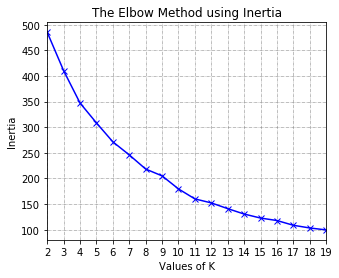

In [265]:
inertia = inertia_k_mean(X)
plot_elbow_graph(inertia)

#### cluster = 4 is a reasonable choice

#### Start modeling

In [282]:
clusterNum = 4
kmeans = KMeans(n_clusters=clusterNum, random_state=23).fit(X)
kmeans.labels_[0:10]

array([3, 2, 1, 1, 1, 1, 2, 1, 1, 3])

In [283]:
# unique value in target column
np.unique(kmeans.labels_)

array([0, 1, 2, 3])

In [284]:
# create a new dataframe that includes the cluster
hou_bar_cluster = grouped_data.copy()
hou_bar_cluster["Cluster Labels"] = kmeans.labels_
hou_bar_cluster.head()

,Neighborhood,bar,restaurant,food_drink,shopping,entertainment,outdoor,others,Cluster Labels
0,Acres Home,0.000000000,0.25,0.000000000,0.250000000,0.000000000,0.000000000,0.500000000,3
1,Addicks / Park Ten,0.000000000,0.00,0.000000000,0.000000000,0.000000000,0.200000000,0.800000000,2
2,Afton Oaks / River Oaks,0.020000000,0.26,0.140000000,0.400000000,0.010000000,0.010000000,0.160000000,1
3,Alief,0.000000000,0.20,0.300000000,0.366666667,0.033333333,0.000000000,0.100000000,1
4,Astrodome Area,0.054347826,0.25,0.217391304,0.250000000,0.010869565,0.032608696,0.184782609,1


In [285]:
# to add latitude/longitude for each neighborhood
hou_bar_cluster = hou_bar_cluster.join(houston_venues.set_index("Neighborhood"), on="Neighborhood")

print(hou_bar_cluster.shape)
hou_bar_cluster.head()

(4168, 15)


,Neighborhood,bar,restaurant,food_drink,shopping,entertainment,outdoor,others,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Acres Home,0.0,0.25,0.0,0.25,0.0,0.0,0.5,3,29.8707190,-95.4365430,Family Dollar,29.872253418,-95.437728882,Discount Store
0,Acres Home,0.0,0.25,0.0,0.25,0.0,0.0,0.5,3,29.8707190,-95.4365430,Amazing Wrecker Service,29.867450000,-95.432419900,Business Service
0,Acres Home,0.0,0.25,0.0,0.25,0.0,0.0,0.5,3,29.8707190,-95.4365430,METRO Acres Homes Transit Center,29.864707947,-95.430969238,Bus Station
0,Acres Home,0.0,0.25,0.0,0.25,0.0,0.0,0.5,3,29.8707190,-95.4365430,Chick Chung,29.863634529,-95.428401530,Chinese Restaurant
1,Addicks / Park Ten,0.0,0.00,0.0,0.00,0.0,0.2,0.8,2,29.8132687,-95.6454759,Bill Archer Dog Park,29.817540064,-95.647512656,Dog Run


In [286]:
# sort the results by Cluster Labels
hou_bar_cluster.sort_values(["Cluster Labels"], inplace=True)
hou_bar_cluster.tail()

,Neighborhood,bar,restaurant,food_drink,shopping,entertainment,outdoor,others,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
38,Harrisburg / Manchester,0.0,0.00,0.0,0.00,0.0,0.0,1.0,3,29.7185281,-95.2601563,Manchester Terminals,29.717309769,-95.249607809,Harbor / Marina
38,Harrisburg / Manchester,0.0,0.00,0.0,0.00,0.0,0.0,1.0,3,29.7185281,-95.2601563,Port of Houston CD 32,29.726954641,-95.265477304,Marine Terminal
38,Harrisburg / Manchester,0.0,0.00,0.0,0.00,0.0,0.0,1.0,3,29.7185281,-95.2601563,Peiser Park,29.716944682,-95.273951080,Park
38,Harrisburg / Manchester,0.0,0.00,0.0,0.00,0.0,0.0,1.0,3,29.7185281,-95.2601563,Charles H Milby Park,29.705946542,-95.263652802,Park
0,Acres Home,0.0,0.25,0.0,0.25,0.0,0.0,0.5,3,29.8707190,-95.4365430,Family Dollar,29.872253418,-95.437728882,Discount Store


#### Visualize Clustering using Folium map

In [345]:
grouped_data["Cluster Labels"] = kmeans.labels_
grouped_data.head()

,Neighborhood,bar,restaurant,food_drink,shopping,entertainment,outdoor,others,Cluster Labels
0,Acres Home,0.000000000,0.25,0.000000000,0.250000000,0.000000000,0.000000000,0.500000000,3
1,Addicks / Park Ten,0.000000000,0.00,0.000000000,0.000000000,0.000000000,0.200000000,0.800000000,2
2,Afton Oaks / River Oaks,0.020000000,0.26,0.140000000,0.400000000,0.010000000,0.010000000,0.160000000,1
3,Alief,0.000000000,0.20,0.300000000,0.366666667,0.033333333,0.000000000,0.100000000,1
4,Astrodome Area,0.054347826,0.25,0.217391304,0.250000000,0.010869565,0.032608696,0.184782609,1


In [288]:
grouped_data_merged = df.join(grouped_data.set_index('Neighborhood'), on='Neighborhood')
print(grouped_data_merged.shape)
grouped_data_merged.head()

(88, 12)


,Neighborhood,Location,Latitude,Longitude,bar,restaurant,food_drink,shopping,entertainment,outdoor,others,Cluster Labels
1,Willowbrook,Northwest,29.9558598,-95.5459787,0.040000000,0.160000000,0.090000000,0.620000000,0.010000000,0.020000000,0.060000000,1
2,Greater Greenspoint,North,29.9406789,-95.4139056,0.032258065,0.322580645,0.241935484,0.225806452,0.016129032,0.016129032,0.145161290,1
3,Carverdale,Northwest,29.8587078,-95.5451620,0.000000000,0.050000000,0.300000000,0.100000000,0.000000000,0.000000000,0.550000000,3
4,Fairbanks / Northwest Crossing,Northwest,29.8509122,-95.5154068,0.035087719,0.210526316,0.210526316,0.438596491,0.000000000,0.052631579,0.052631579,1
5,Greater Inwood,Northwest,29.8657387,-95.4804344,0.000000000,0.166666667,0.233333333,0.300000000,0.000000000,0.000000000,0.300000000,1


In [342]:
grouped_data_merged.to_csv("Hou_grouped_venues_cluster.csv")

In [340]:
import folium
from folium.features import DivIcon

# get center coordinates of Houston and map it
# lat_hou, lon_hou = google_get_coordinates(api_key, "Houston, TX")

# create map
map_clusters = folium.Map(location=[lat_hou, lon_hou], zoom_start=10)

# set color scheme for the clusters
x = np.arange(clusterNum)
ys = [i+x+(i*x)**2 for i in range(clusterNum)]
# colors are: green, red, orange, aqua, fuchsia
color_list = ['#0000FF','#FF0000','#FFA500','#008000','#FF00FF']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(grouped_data_merged['Latitude'], grouped_data_merged['Longitude'], \
                                  grouped_data_merged['Neighborhood'], grouped_data_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=color_list[cluster],
        fill=True,
        fill_color=color_list[cluster],
        fill_opacity=0.8).add_to(map_clusters)

map_clusters



## 5. Result and Discussion  <a name="result"></a>
### 5.1 Analysis of each Neighborhood Cluster

In [290]:
def get_cluster_df(cluster_num):
    cluster_temp = grouped_data.loc[grouped_data['Cluster Labels'] == cluster_num -1]
    cluster_df = pd.merge(df[['Neighborhood', 'Location']], cluster_temp, on='Neighborhood')
    return cluster_df

In [291]:
df_c1 = get_cluster_df(1)
df_c2 = get_cluster_df(2)
df_c3 = get_cluster_df(3)
df_c4 = get_cluster_df(4)

In [341]:
df_c1.head()

,Neighborhood,Location,bar,restaurant,food_drink,shopping,entertainment,outdoor,others,Cluster Labels
0,Lazybrook / Timbergrove,Northwest,0.097222222,0.263888889,0.180555556,0.222222222,0.000000000,0.041666667,0.194444444,0
1,Westchase,West,0.059523810,0.309523810,0.273809524,0.142857143,0.023809524,0.035714286,0.154761905,0
2,Washington Avenue Coalition / Memorial Park,West,0.066666667,0.116666667,0.100000000,0.150000000,0.033333333,0.083333333,0.450000000,0
3,Neartown / Montrose,Southwest,0.160000000,0.230000000,0.230000000,0.250000000,0.000000000,0.010000000,0.120000000,0
4,University Place,Southwest,0.090000000,0.230000000,0.190000000,0.310000000,0.010000000,0.010000000,0.160000000,0


In [306]:
df_c1.groupby("Location").count()

,Neighborhood,bar,restaurant,food_drink,shopping,entertainment,outdoor,others,Cluster Labels
Location,,,,,,,,,
East,1,1,1,1,1,1,1,1,1
Northeast,1,1,1,1,1,1,1,1,1
Northwest,1,1,1,1,1,1,1,1,1
South,4,4,4,4,4,4,4,4,4
Southeast,1,1,1,1,1,1,1,1,1
Southwest,3,3,3,3,3,3,3,3,3
West,3,3,3,3,3,3,3,3,3
—,1,1,1,1,1,1,1,1,1


In [307]:
df_c2.groupby("Location").count()

,Neighborhood,bar,restaurant,food_drink,shopping,entertainment,outdoor,others,Cluster Labels
Location,,,,,,,,,
East,3,3,3,3,3,3,3,3,3
North,6,6,6,6,6,6,6,6,6
Northeast,5,5,5,5,5,5,5,5,5
Northwest,8,8,8,8,8,8,8,8,8
South,3,3,3,3,3,3,3,3,3
Southeast,10,10,10,10,10,10,10,10,10
Southwest,11,11,11,11,11,11,11,11,11
West,7,7,7,7,7,7,7,7,7


In [308]:
df_c3.groupby("Location").count()

,Neighborhood,bar,restaurant,food_drink,shopping,entertainment,outdoor,others,Cluster Labels
Location,,,,,,,,,
East,1,1,1,1,1,1,1,1,1
Northeast,2,2,2,2,2,2,2,2,2
Northwest,1,1,1,1,1,1,1,1,1
South,1,1,1,1,1,1,1,1,1
Southeast,2,2,2,2,2,2,2,2,2
Southwest,1,1,1,1,1,1,1,1,1
West,2,2,2,2,2,2,2,2,2


In [309]:
df_c4.groupby("Location").count()

,Neighborhood,bar,restaurant,food_drink,shopping,entertainment,outdoor,others,Cluster Labels
Location,,,,,,,,,
East,1,1,1,1,1,1,1,1,1
Northeast,3,3,3,3,3,3,3,3,3
Northwest,2,2,2,2,2,2,2,2,2
South,3,3,3,3,3,3,3,3,3
Southeast,1,1,1,1,1,1,1,1,1


### 5.2. Number of neighborhoods per cluster *vs* Average number of Bars in each Cluster?

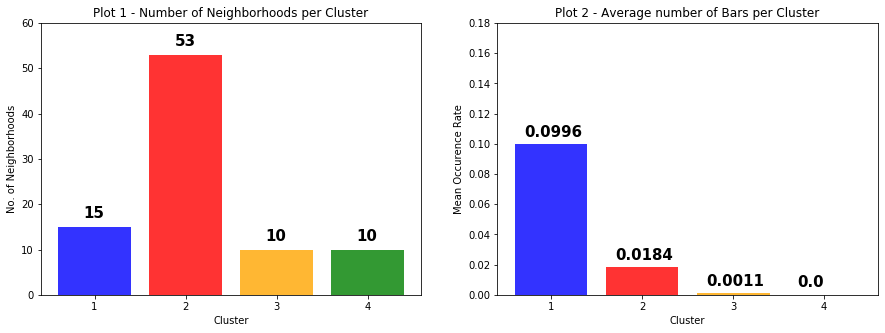

In [357]:
plt.figure(figsize=(15,5))
objects = tuple(range(1, clusterNum+1))
# print(objects)
# Plot-1 ( Number of Neighborhoods per Cluster )

plt.subplot(1,2,1)
y_pos = np.arange(len(objects))
# print(y_pos+1)
performance = grouped_data['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
plt.bar(y_pos, performance['Cluster Labels'].tolist(), align='center', alpha=0.8, color=color_list)
plt.xticks(y_pos, objects)
plt.ylim(0, 60)
plt.ylabel('No. of Neighborhoods')
plt.xlabel('Cluster')
for i in performance.index:
    plt.text(i - 0.12, performance.iloc[i][0] + 2, str(performance.iloc[i][0]), fontsize=15, weight="bold")
plt.title('Plot 1 - Number of Neighborhoods per Cluster')

# Plot-2 ( Average number of Bars per Cluster )

plt.subplot(1, 2, 2)
clusters_mean = [df_c1['bar'].mean(),df_c2['bar'].mean(),df_c3['bar'].mean(),df_c4['bar'].mean()]
y_pos = np.arange(len(objects))
plt.bar(y_pos, clusters_mean, align='center', alpha=0.8, color=color_list)
plt.xticks(y_pos, objects)
plt.ylim(0, 0.18)
plt.ylabel('Mean Occurence Rate')
plt.xlabel('Cluster')
for i in range(len(clusters_mean)):
    plt.text(i-0.3, clusters_mean[i]+0.005, str(clusters_mean[i])[:6], fontsize=15, weight="bold")
plt.title('Plot 2 - Average number of Bars per Cluster')


plt.show()

In [299]:
# grouped_data.head()

### 5.3. Find some correlations

In [302]:
rank_data = grouped_data.groupby('Cluster Labels').mean().iloc[:, 0:7]
my_rank = rank_data/rank_data.sum()
my_rank["color"] = ["blue", "red", "yellow", "green"]
my_rank

,bar,restaurant,food_drink,shopping,entertainment,outdoor,others,color
Cluster Labels,,,,,,,,
0,0.835757279,0.319180814,0.284749021,0.222287626,0.707742881,0.121221877,0.177137435,blue
1,0.154489424,0.360482102,0.335345633,0.356936229,0.233961188,0.093803019,0.128747214,red
2,0.009753296,0.194841619,0.335077134,0.193629666,0.058295931,0.784975104,0.236392642,yellow
3,0.000000000,0.125495465,0.044828211,0.227146479,0.000000000,0.000000000,0.457722708,green


In [312]:
# print(color_list)
labels = grouped_data['Cluster Labels']
# print(labels)
colors = []
for l in labels:
    colors.append(color_list[int(l)])
print(colors)

['#008000', '#FFA500', '#FF0000', '#FF0000', '#FF0000', '#FF0000', '#FFA500', '#FF0000', '#FF0000', '#008000', '#FF0000', '#008000', '#FF0000', '#008000', '#FF0000', '#0000FF', '#FF0000', '#FF0000', '#FF0000', '#008000', '#FF0000', '#FF0000', '#FF0000', '#FF0000', '#0000FF', '#FF0000', '#0000FF', '#0000FF', '#FF0000', '#FF0000', '#FF0000', '#FF0000', '#FF0000', '#FF0000', '#FF0000', '#FF0000', '#FF0000', '#FF0000', '#008000', '#FF0000', '#FFA500', '#FF0000', '#FF0000', '#FF0000', '#FF0000', '#FF0000', '#008000', '#FF0000', '#FF0000', '#0000FF', '#FF0000', '#FF0000', '#FFA500', '#FFA500', '#FF0000', '#FF0000', '#FF0000', '#0000FF', '#008000', '#0000FF', '#0000FF', '#FF0000', '#FF0000', '#FF0000', '#FFA500', '#FF0000', '#FFA500', '#0000FF', '#008000', '#FF0000', '#0000FF', '#FF0000', '#0000FF', '#008000', '#FF0000', '#FF0000', '#FFA500', '#FF0000', '#FF0000', '#FFA500', '#0000FF', '#0000FF', '#FFA500', '#0000FF', '#0000FF', '#FF0000', '#FF0000', '#FF0000']


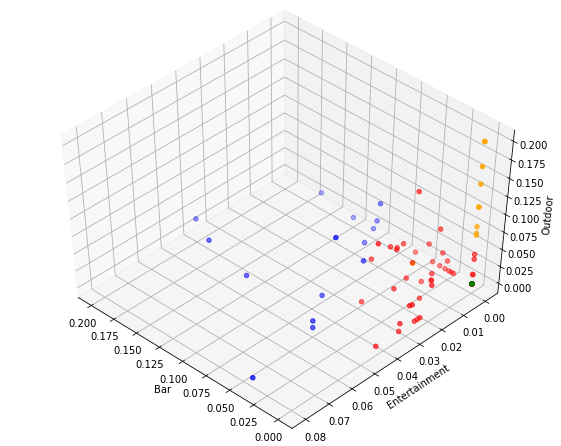

In [313]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()

ax.set_xlabel('Bar')
ax.set_ylabel('Entertainment')
ax.set_zlabel('Outdoor')

ax.scatter(raw_X[:, 0].astype(np.float), raw_X[:, 4].astype(np.float), raw_X[:, 5].astype(np.float), c= colors)

## 6. Conclusion <a name="conclusion"></a>

Based on the analysis above, especially the clustering map and the 3D scatter plot, the conclusion is as follow:
* Interestingly, in all these venues, there is a positive correlation between the bars and entertainments, but negative correlations between bars and outdoor or other venues.
* The neighborhood cluster-1 (label-0, blue) includes the most amount of bars, as well as the most number of entertainments, but fewer outdoor and other venues; There are 15 neighborhoods in this cluster, and most of them are close to the center of the city. These neighborhoods are good, but to open a new bar, it might be quite competitive.
* The neighborhood cluster-2 (label-1, red) is the biggest group, which has 57 neighborhoods in it. There are plenty of restaurants, other food and drinks, shopping facilities, entertainments, and a few outdoor and other venues. Surprisingly, there is only a few numbers of bars in this cluster. The neighborhoods in this cluster could be a good choice to open a new bar.
* There are 10 neighborhoods in cluster-3 (label-2, yellow). In this cluster, there are only a few bars and entertainments, with a number of outdoor and other venues. The locations are quite far away from the city center.
* Lastly, in cluster-4 (label-3, green), it also has 10 neighborhoods. No bar, outdoor or entertainment can be found. If you don't want competition, then these neighborhoods are the best choice.

**In conclusion, cluster2 is the best choice for more competitive new bars, while cluster4 can be the best for new bars don't want to compete with other bars.**

##  7. Future Work <a name="future"></a>

* Look into each cluster and analyzing them with more details;
* Try other clustering algorithms or consider different structure of the features used in cluster modelling;
* Use more than 100 venues and bigger radius in one neighborhood for analysis from Foursquare api.